## Preparation

**Package installation**

In [ ]:
!pip install dill
!pip3 install -q pybind11
!pip uninstall -q --yes gdown
!pip install -q gdown -U --no-cache-dir
!pip3 install -q --upgrade --no-deps git+https://github.com/dlsys10714/mugrade.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.4/222.4 KB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


**Clone github repo**

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !git clone https://github.com/Edyarich/dlsystems-final-project
    %cd dlsystems-final-project
    !git checkout testing
    !make

Cloning into 'dlsystems-final-project'...
remote: Enumerating objects: 455, done.
remote: Counting objects: 100% (455/455), done.
remote: Compressing objects: 100% (299/299), done.
remote: Total 455 (delta 195), reused 370 (delta 119), pack-reused 0
Receiving objects: 100% (455/455), 8.95 MiB | 16.42 MiB/s, done.
Resolving deltas: 100% (195/195), done.
/content/dlsystems-final-project
Branch 'testing' set up to track remote branch 'testing' from 'origin'.
Switched to a new branch 'testing'
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
--

**Download the dataset of landscapes**

In [ ]:
import sys
import os
import gdown
import importlib
from data.utils import rename_and_filter_images
import urllib.request

sys.path.append('./python')

%cd ./data
DIRNAME = './landscapes/'

if not os.path.exists(DIRNAME):
    !gdown 14g49ILtIYKLt7WXaRPYyVfJGLHxcnQ7s
    !unzip -q landscapes -d landscapes
    !rm landscapes.zip

    rename_and_filter_images(DIRNAME)

%cd ../

/content/dlsystems-final-project/data
Downloading...
From: https://drive.google.com/uc?id=14g49ILtIYKLt7WXaRPYyVfJGLHxcnQ7s
To: /content/dlsystems-final-project/data/landscapes.zip
100% 650M/650M [00:15<00:00, 42.8MB/s]
/content/dlsystems-final-project


**Imports**

In [ ]:
import needle as ndl
import needle.nn as nn
from apps.diffusion import Unet, Diffusion
from needle import array_api, Tensor, NDArray
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

**Image example**

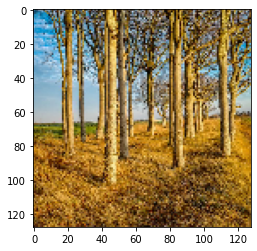

In [ ]:
from pathlib import Path
from needle.autograd import Tensor


def plot_landscape(img):
    img = np.transpose(img, (1, 2, 0))
    img = (img + 1) / 2
    plt.imshow(img);


DATA_DIR = Path('./data/landscapes/')
IMAGE_FILES = sorted(str(x) for x in list(DATA_DIR.rglob('*.jpg')))

transforms = [
    ndl.data.RandomFlipHorizontal(),
    ndl.data.Lambda(lambda img: np.transpose(img, (2, 0, 1))),
]

dataset = ndl.data.LandscapesDataset(
    IMAGE_FILES, extra_transforms=transforms, img_size=128
)
plot_landscape(dataset[12])

## Training

**Initialize model and optimizer, set hyperparameters**

In [ ]:
device = ndl.cuda()
model = Unet((32, 64, 128), device=device)
optimizer = ndl.optim.Adam(model.parameters(), lr=1e-3)

timesteps = 300
module = Diffusion(model, timesteps, loss_type="l2", device=device)

epochs = 2
batch_size = 12
dataloader = ndl.data.DataLoader(dataset, batch_size, device=device)

**Print noised landscape**

In [1]:
# noised_img = module.q_sample(Tensor(dataset[12], device=device), Tensor([150], device=device))
# img_to_show = noised_img.numpy()
# plt.imshow(img_to_show);

**Training**

In [ ]:
import torch, gc


CHECKPOINT_STEP = 1

for epoch in range(epochs):
    for step, batch in enumerate(tqdm(dataloader)):
        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        optimizer.reset_grad()
        
        t = Tensor(np.random.randint(0, timesteps, (batch.shape[0],)),
                   device=device,
                   requires_grad=False)

        loss = module.p_losses(batch, t)

        if step % 10 == 0:
            print("Loss:", loss.cached_data[0])
            # print(torch.cuda.mem_get_info(device=torch.device("cuda:0")))

        loss.backward()
        optimizer.step()
        gc.collect()
        torch.cuda.empty_cache()

    if (epoch + 1) % CHECKPOINT_STEP == 0:
        ndl.save(model.state_dict(), 'diffusion.dill')

  0%|          | 0/360 [00:00<?, ?it/s]

Loss: [1.8684316]


  3%|▎         | 10/360 [00:56<33:13,  5.69s/it]

Loss: [1.028174]


  6%|▌         | 20/360 [01:53<32:24,  5.72s/it]

Loss: [0.945332]


  8%|▊         | 30/360 [02:50<31:28,  5.72s/it]

Loss: [0.8828976]


 11%|█         | 40/360 [03:48<30:32,  5.73s/it]

Loss: [0.8369224]


 14%|█▍        | 50/360 [04:45<29:27,  5.70s/it]

Loss: [0.78366244]


 17%|█▋        | 60/360 [05:42<28:34,  5.71s/it]

Loss: [0.70824575]


 19%|█▉        | 70/360 [06:39<27:33,  5.70s/it]

Loss: [0.6354539]


 22%|██▏       | 80/360 [07:36<26:47,  5.74s/it]

Loss: [0.58925223]


 25%|██▌       | 90/360 [08:33<25:41,  5.71s/it]

Loss: [0.6304064]


 28%|██▊       | 100/360 [09:31<24:46,  5.72s/it]

Loss: [0.59701717]


 31%|███       | 110/360 [10:29<24:09,  5.80s/it]

Loss: [0.5661105]


 33%|███▎      | 120/360 [11:27<22:59,  5.75s/it]

Loss: [0.51442313]


 36%|███▌      | 130/360 [12:24<21:52,  5.71s/it]

Loss: [0.5240311]


 39%|███▉      | 140/360 [13:21<20:57,  5.72s/it]

Loss: [0.56658226]


 42%|████▏     | 150/360 [14:18<19:55,  5.69s/it]

Loss: [0.55836177]


 44%|████▍     | 160/360 [15:15<18:58,  5.69s/it]

Loss: [0.46785212]


 47%|████▋     | 170/360 [16:12<18:02,  5.70s/it]

Loss: [0.50356525]


 50%|█████     | 180/360 [17:09<17:05,  5.70s/it]

Loss: [0.42549562]


 53%|█████▎    | 190/360 [18:06<16:07,  5.69s/it]

Loss: [0.5023121]


 56%|█████▌    | 200/360 [19:03<15:11,  5.70s/it]

Loss: [0.45180184]


 58%|█████▊    | 210/360 [19:59<14:13,  5.69s/it]

Loss: [0.40918472]


 61%|██████    | 220/360 [20:56<13:18,  5.70s/it]

Loss: [0.4115091]


 64%|██████▍   | 230/360 [21:54<12:21,  5.71s/it]

Loss: [0.5025669]


 67%|██████▋   | 240/360 [22:50<11:20,  5.67s/it]

Loss: [0.3981713]


 69%|██████▉   | 250/360 [23:47<10:26,  5.70s/it]

Loss: [0.4097668]


 72%|███████▏  | 260/360 [24:44<09:27,  5.67s/it]

Loss: [0.42011848]


 75%|███████▌  | 270/360 [25:41<08:32,  5.69s/it]

Loss: [0.4442637]


 78%|███████▊  | 280/360 [26:38<07:38,  5.73s/it]

Loss: [0.4097268]


 81%|████████  | 290/360 [27:35<06:37,  5.68s/it]

Loss: [0.456969]


 83%|████████▎ | 300/360 [28:32<05:39,  5.66s/it]

Loss: [0.43072993]


 86%|████████▌ | 310/360 [29:28<04:44,  5.68s/it]

Loss: [0.45971993]


 89%|████████▉ | 320/360 [30:25<03:46,  5.67s/it]

Loss: [0.43323472]


 92%|█████████▏| 330/360 [31:22<02:50,  5.69s/it]

Loss: [0.37706938]


 94%|█████████▍| 340/360 [32:19<01:54,  5.72s/it]

Loss: [0.46782854]


 97%|█████████▋| 350/360 [33:16<00:56,  5.67s/it]

Loss: [0.3689903]


  0%|          | 0/360 [00:00<?, ?it/s]

Loss: [0.34843957]


  3%|▎         | 10/360 [00:58<33:56,  5.82s/it]

Loss: [0.4167057]


  6%|▌         | 20/360 [01:55<32:41,  5.77s/it]

Loss: [0.34086692]


  8%|▊         | 30/360 [02:53<31:50,  5.79s/it]

Loss: [0.32886323]


 11%|█         | 40/360 [03:51<30:46,  5.77s/it]

Loss: [0.36930692]


 14%|█▍        | 50/360 [04:49<29:46,  5.76s/it]

Loss: [0.402112]


 17%|█▋        | 60/360 [05:46<28:50,  5.77s/it]

Loss: [0.3906043]


 19%|█▉        | 70/360 [06:44<27:49,  5.76s/it]

Loss: [0.31247115]


 22%|██▏       | 80/360 [07:41<26:50,  5.75s/it]

Loss: [0.34137732]


 25%|██▌       | 90/360 [08:39<26:12,  5.82s/it]

Loss: [0.33549324]


 28%|██▊       | 100/360 [09:37<24:58,  5.76s/it]

Loss: [0.46684757]


 31%|███       | 110/360 [10:34<23:54,  5.74s/it]

Loss: [0.41791263]


 33%|███▎      | 120/360 [11:32<23:06,  5.78s/it]

Loss: [0.35119155]


 36%|███▌      | 130/360 [12:30<22:04,  5.76s/it]

Loss: [0.34501374]


 39%|███▉      | 140/360 [13:27<21:04,  5.75s/it]

Loss: [0.372296]


 42%|████▏     | 150/360 [14:25<20:08,  5.75s/it]

Loss: [0.29274315]


 44%|████▍     | 160/360 [15:23<19:10,  5.75s/it]

Loss: [0.30789912]


 47%|████▋     | 170/360 [16:20<18:15,  5.77s/it]

Loss: [0.33921918]


 50%|█████     | 180/360 [17:18<17:19,  5.77s/it]

Loss: [0.3570281]


 53%|█████▎    | 190/360 [18:16<16:52,  5.95s/it]

Loss: [0.29516566]


 56%|█████▌    | 200/360 [19:15<15:30,  5.81s/it]

Loss: [0.35921344]


 58%|█████▊    | 210/360 [20:14<14:44,  5.90s/it]

Loss: [0.32416064]


 60%|██████    | 217/360 [20:57<13:48,  5.80s/it]


RuntimeError: ignored

**Save checkpoint**

In [ ]:
if IN_COLAB:
    from google.colab import files
    files.download('diffusion.dill') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference

In [ ]:
result = module.sample(128, 6, 3)

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

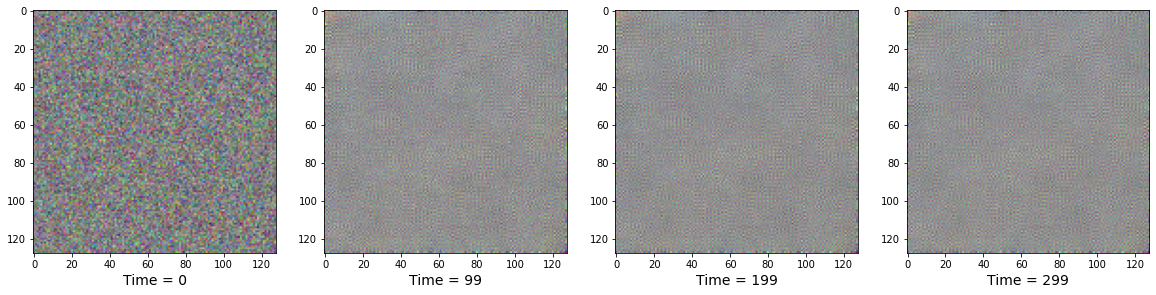

In [41]:
n_rows, n_cols = 1, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))

for i, img_num in zip(range(n_rows), [3]):
    for j, ts in zip(range(n_cols), np.linspace(0, timesteps-1, n_cols, dtype=int)):
        img = result[ts][i]
        img = (img - img.min()) / (img.max() - img.min())
        img = np.transpose(img, (1, 2, 0))
        axes[j].imshow(img)
        axes[j].set_xlabel(f'Time = {ts}', fontsize=14)

## Tests for Maxpool and ConvTranspose

In [43]:
!python3 -m pytest -l -v -k "op_maxpool"

============================= test session starts ==============================
platform linux -- Python 3.8.16, pytest-3.6.4, py-1.11.0, pluggy-0.7.1 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/dlsystems-final-project, inifile:
plugins: typeguard-2.7.1
collected 1881 items / 1833 deselected                                         

tests/test_conv.py::test_op_maxpool[backward-device0-X_shape0-2] PASSED  [  2%]
tests/test_conv.py::test_op_maxpool[backward-device0-X_shape1-2] PASSED  [  4%]
tests/test_conv.py::test_op_maxpool[backward-device0-X_shape2-2] PASSED  [  6%]
tests/test_conv.py::test_op_maxpool[backward-device0-X_shape3-2] PASSED  [  8%]
tests/test_conv.py::test_op_maxpool[backward-device0-X_shape4-2] PASSED  [ 10%]
tests/test_conv.py::test_op_maxpool[backward-device0-X_shape5-2] PASSED  [ 12%]
tests/test_conv.py::test_op_maxpool[backward-device0-X_shape6-3] PASSED  [ 14%]
tests/test_conv.py::test_op_maxpool[backward-device0-X_shape7-3] PASSED  [ 16%]
tests/

In [44]:
!python3 -m pytest -l -v -s -k "nn_conv_tr_forward"

============================= test session starts ==============================
platform linux -- Python 3.8.16, pytest-3.6.4, py-1.11.0, pluggy-0.7.1 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/dlsystems-final-project, inifile:
plugins: typeguard-2.7.1
collected 1881 items / 1865 deselected                                         

tests/test_conv.py::test_nn_conv_tr_forward[device0-2-1-1-3-2-1] PASSED
tests/test_conv.py::test_nn_conv_tr_forward[device0-2-1-2-3-2-1] PASSED
tests/test_conv.py::test_nn_conv_tr_forward[device0-4-8-8-3-1-0] PASSED
tests/test_conv.py::test_nn_conv_tr_forward[device0-4-8-16-3-2-1] PASSED
tests/test_conv.py::test_nn_conv_tr_forward[device0-16-8-16-3-1-1] PASSED
tests/test_conv.py::test_nn_conv_tr_forward[device0-16-16-8-3-2-2] PASSED
tests/test_conv.py::test_nn_conv_tr_forward[device0-32-8-8-3-1-2] PASSED
tests/test_conv.py::test_nn_conv_tr_forward[device0-32-16-8-3-2-0] PASSED
tests/test_conv.py::test_nn_conv_tr_forward[device1-2-1-1-3-2-

In [45]:
!python3 -m pytest -l -v -k "nn_conv_tr_backward"

============================= test session starts ==============================
platform linux -- Python 3.8.16, pytest-3.6.4, py-1.11.0, pluggy-0.7.1 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/dlsystems-final-project, inifile:
plugins: typeguard-2.7.1
collected 1881 items / 1867 deselected                                         

tests/test_conv.py::test_nn_conv_tr_backward[device0-2-1-1-3-2-1] PASSED [  7%]
tests/test_conv.py::test_nn_conv_tr_backward[device0-2-1-2-3-2-1] PASSED [ 14%]
tests/test_conv.py::test_nn_conv_tr_backward[device0-4-8-8-3-1-0] PASSED [ 21%]
tests/test_conv.py::test_nn_conv_tr_backward[device0-4-8-16-3-2-1] PASSED [ 28%]
tests/test_conv.py::test_nn_conv_tr_backward[device0-16-8-16-3-1-1] PASSED [ 35%]
tests/test_conv.py::test_nn_conv_tr_backward[device0-16-16-8-3-2-2] PASSED [ 42%]
tests/test_conv.py::test_nn_conv_tr_backward[device0-24-8-8-3-1-2] PASSED [ 50%]
tests/test_conv.py::test_nn_conv_tr_backward[device1-2-1-1-3-2-1] PASSED [ 57%]
